In [1]:
import swat
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import cas_connection as cas

import warnings
warnings.filterwarnings("ignore", category = UserWarning)
import osmnx as ox
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import json
import pickle

# Introduction

Use SAS Network Analytics to help plan your trip to the next total solar eclipse. On April 8, 2024, there will be a total solar eclipse that spans from the southwestern to northeastern United States. This will be the last total solar eclipse that crosses the contiguous United States until 2044.

# Road Network Data

OpenStreetMap (OSM)[<sup>[1]</sup>]() is a free, community-maintained database of geographic features worldwide including landmarks and transportation networks. OSM combines official datasets from the public domain with additional data collected from satellite imagery, GPS tracking, and ground survey. As one of the most comprehensive open geodata sources publicly available, it is commonly used for mapping and navigation projects.

The Python package OSMnx is an open source toolkit for conveniently retrieving, converting, and analyzing OSM data as graphs. We use OSMnx to help generate a road network from the OSM data of the major roads and highways in the contiguous United States. Then, using SAS Viya through the SWAT package, we can perform various analyses on the resulting network.

For more details, see the OSM application example in this repository.

In [2]:
DATAPATH=os.path.join(os.path.dirname(os.getcwd()), 'data/') # This must specify the folder where you are storing the data files

# Get the polygon representing the contiguous USA
us_gdf = ox.geocode_to_gdf('USA')
us_polys = us_gdf.explode(index_parts=False).reset_index()
us_polys['Area'] = us_polys.area
us_poly_gdf = us_polys[us_polys['Area']==us_polys['Area'].max()]
contiguous_us_poly = us_poly_gdf['geometry'].values[0]

# Query for the road networks (takes a long time to run) and save the results:
# ox.settings.log_console = True
# ox.settings.max_query_area_size = 25e10
# G_us_poly = ox.graph_from_polygon(contiguous_us_poly, network_type = 'drive',
#                                   custom_filter = '["highway"~"motorway|trunk|primary|motorway_link|trunk_link|primary_link"]', truncate_by_edge = True, retain_all = True)
# ox.save_graphml(G_us_poly, filepath = DATAPATH+'graph_US_poly.graphml')

# Reload from saved version
G_US_roads = ox.load_graphml(DATAPATH+'graph_US_poly.graphml')

# Take the largest strongly connected component to remove any isolated locations
G_US_roads_scc = nx.subgraph(G_US_roads, max(nx.strongly_connected_components(G_US_roads), key = len))

print(f"Number of nodes: {G_US_roads_scc.number_of_nodes()}")
print(f"Number of edges: {G_US_roads_scc.number_of_edges()}")

Number of nodes: 476137
Number of edges: 799057


Finally, because OSM includes data on speed limits, we can use a combination of estimated road speed and distance to form a better approximation of travel time than road distance alone provides.  OSMnx includes convenient tools to impute missing road speeds and then add a travel time attribute to each edge.

In [3]:
G_US_roads_scc = ox.speed.add_edge_speeds(G_US_roads_scc)
G_US_roads_scc = ox.speed.add_edge_travel_times(G_US_roads_scc)

# NASA Data

NASA has various data related to the eclipse, such as shapefiles that contain polygons representing the umbra and the path it makes across the country, as well as a JSON file that contains the coordinates of the major cities in the US. The data can be found here: [https://svs.gsfc.nasa.gov/5073](https://svs.gsfc.nasa.gov/5073)

We can use the city data to give names to some of the nodes in the dataset so that we have named locations to base our analytics around and not just arbitrary integers that represent road intersections.

In [4]:
with open(DATAPATH+'cities-eclipse-2024.json', 'r') as f:
    data = json.load(f)

# Get all cities and their lat/lon coordinates
def to_label(d):
    return ",".join([str(d[x]) for x in ['NAME', 'STATE', 'LON', 'LAT']]) # Need LON/LAT to differentiate same city names

city_nodes_labels = [to_label(d) for d in data]
city_nodes_xcoords = [d['LON'] for d in data]
city_nodes_ycoords = [d['LAT'] for d in data]

# Find the closest node to each city coordinate
res = ox.distance.nearest_nodes(G_US_roads_scc, city_nodes_xcoords, city_nodes_ycoords)

# Add the city label as an attribute to that node only
mapping = dict(zip(res, city_nodes_labels))
city_to_node = {v:k for k,v in mapping.items()}
nx.set_node_attributes(G_US_roads_scc, values=mapping, name='city')

# Converting the graph's nodes and edges into geodataframes is convenient for visualization and analyses.
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_US_roads_scc)
edges_gdf.reset_index(inplace=True)
nodes_gdf['node'] = nodes_gdf.index
edges_gdf.rename(columns={'u':'from', 'v':'to'}, inplace=True)

Next, we can load the shapefiles related to the path of totality. The only file we need is the duration shape file, which gives us a dataframe containing the polygons of the path of the umbra at different duration levels. There are eight polygons in the dataframe: one for each duration lasting from 30 seconds to 240 seconds in 30-second increments.

In [5]:
duration_gdf = gpd.read_file(DATAPATH+'duration.shp')
max_duration = duration_gdf.Duration.max()

Finally, we augment the nodes data with the duration data of the eclipse. For each node inside the path of the eclipse, we add the duration value to the dataframe.

In [6]:
# Get the cities inside the total eclipse path
upath_geom = duration_gdf.geometry.values[-1] # use the widest duration band as a general umbra path
cities_df = nodes_gdf[nodes_gdf.city.notna()]
cities_inside_gdf = cities_df[cities_df.geometry.within(upath_geom)].copy()

cities_dur = gpd.sjoin(cities_inside_gdf, duration_gdf).rename(columns={"Duration":"duration"})
cities_inside_gdf = cities_dur.sort_values(by="duration", ascending=False).drop_duplicates(["node"])

nodes_gdf.loc[cities_inside_gdf.index, 'duration'] = cities_inside_gdf['duration']    

At this point, we have geopandas dataframes for the road network and the path of totality and we can begin doing some more graph analytics. First, let's visualize the road networks along with the path of totality for the continental USA.

<Axes: >

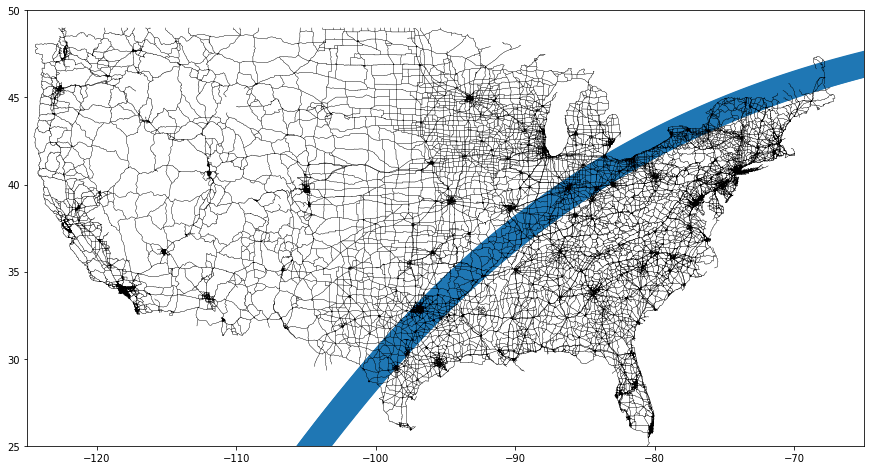

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = ax.set_xlim((-125,-65))
_ = ax.set_ylim((25,50))

duration_gdf.plot(ax=ax, zorder=0)
edges_gdf.plot(ax=ax, linewidth=0.25, zorder=1, color='black')

Our analytics will be done focusing on the eastern half of the USA, so we can limit the view of the plot based on longitude and then store this plot to visualize subsequent analytics results on top.

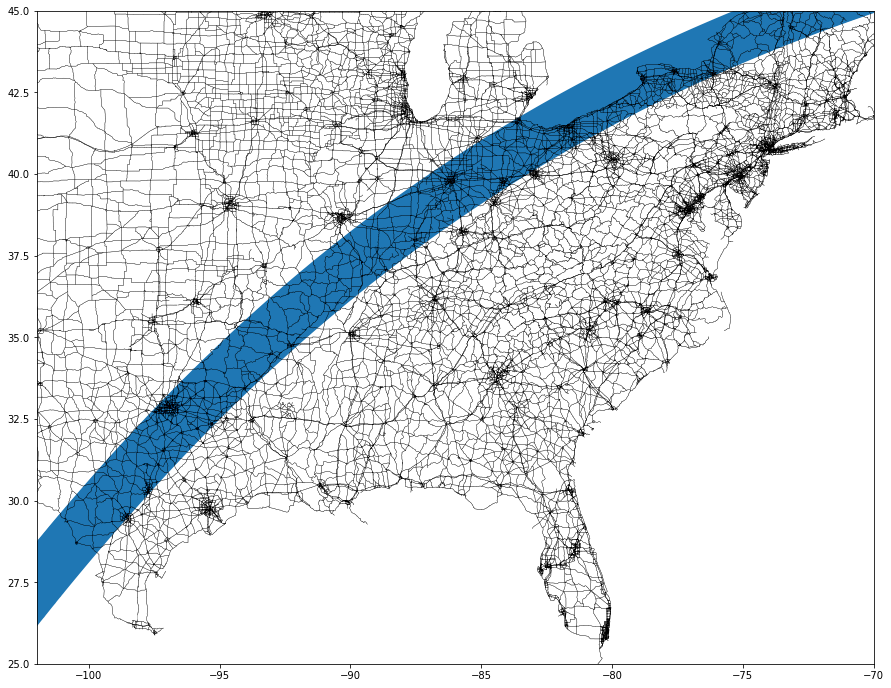

In [8]:
# Store axis for use in other notebook cells without having to regenerate plot
fig_full_bytes = str(pickle.dumps(fig), encoding="latin1")
def full_road_plot():
    fig = pickle.loads(bytes(fig_full_bytes, encoding="latin1"))
    return fig, fig.axes[0]

_ = ax.set_xlim((-102,-70))
_ = ax.set_ylim((25,45))
fig_eastern_bytes = str(pickle.dumps(fig), encoding="latin1")
def eastern_road_plot():
    fig = pickle.loads(bytes(fig_eastern_bytes, encoding="latin1"))
    return fig, fig.axes[0]

f, ax = eastern_road_plot()
f

# CAS Setup

In [9]:
s = cas.reconnect()
swat.options.cas.print_messages = False
s.loadActionSet('network')

[actionset]

 'network'

+ Elapsed: 0.00308s, user: 0.00205s, sys: 0.00102s, mem: 0.252mb

 We will load the datasets into CAS, and since we are going to be performing multiple algorithms on this data, we will go ahead and perform the loadGraph action so that the graph persists in memory between action calls, improving the performance.

In [10]:
s.upload(edges_gdf[['from','to','travel_time']], casout={'name':'links', 'replace':True})
s.upload(nodes_gdf, casout={'name':'nodes', 'replace':True})
s.upload(cities_inside_gdf, casout={'name':'cities_inside', 'replace':True})

res = s.network.loadGraph(
    direction      = 'directed',
    links          = {'name': 'links'},
    linksVar       = {'weight': 'travel_time'},
)

gid = res.graph # save the graph identifier

# Closest Point to Totality from SAS Headquarters

We use the shortestPath action to compute the shortest path from SAS headquarters in Cary, North Carolina to all cities in the path totality. To do this, we set our source node as Cary, NC and our sink node as every city node that is inside the path of totality. Then, we examine results and find the source/sink pair with lowest path weight. For fun, we also depict the shortest path with the highest total weight as well, which would be the city farthest away Cary that is in the total eclipse.

In [11]:
cary_node = city_to_node["Cary,NC,-78.823444,35.781302"]

node_subset = cities_inside_gdf[['node']].copy()
node_subset['sink'] = 1
s.upload(node_subset, casout={'name':'node_subset', 'replace':True})

res = s.network.shortestPath(
    graph          = gid,
    nodesSubset    = {'name': 'node_subset'},
    source         = cary_node,    
    outPathsLinks  = {'name': 'outPathsLinks', 'replace':True},
    outWeights     = {'name': 'outWeights', 'replace':True},
)

opw = s.CASTable('outWeights')
opl = s.CASTable('outPathsLinks')

In [12]:
# Define some functions to help with plotting and printing route information
def plot_path(ax, opl, source=None, sink=None):
    gdf = opl
    if source is not None:
        gdf = gdf[gdf.source == source]
    if sink is not None:
        gdf = gdf[gdf.sink == sink]
    gdf = gdf[['from','to','order']].to_frame()
    gdf = pd.merge(edges_gdf, gdf, on=['from','to'], how='inner')

    gdf.plot(ax=ax, linewidth=4, zorder=3, color='red')
    if source is not None:
        nodes_gdf.loc[[source]].plot(ax=ax, zorder=2, color='red', markersize=150)
    if sink is not None:
        nodes_gdf.loc[[sink]].plot(ax=ax, zorder=2, color='red', markersize=150)        


def print_drive_duration(source, sink, pathweight):
    drive_time = round(pathweight / 60. / 60., 2)
    source_city = nodes_gdf.loc[source].city
    sink_city = nodes_gdf.loc[sink].city
    duration = int(nodes_gdf.loc[sink].duration)
    print(f"Eclipse at '{sink_city}' with duration {duration}s and drive time {drive_time}hrs from '{source_city}'.")    

Eclipse at 'Wilberforce,OH,-83.884442,39.714974' with duration 60s and drive time 7.52hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Box Canyon,TX,-101.15861,29.533512' with duration 60s and drive time 23.55hrs from 'Cary,NC,-78.823444,35.781302'.


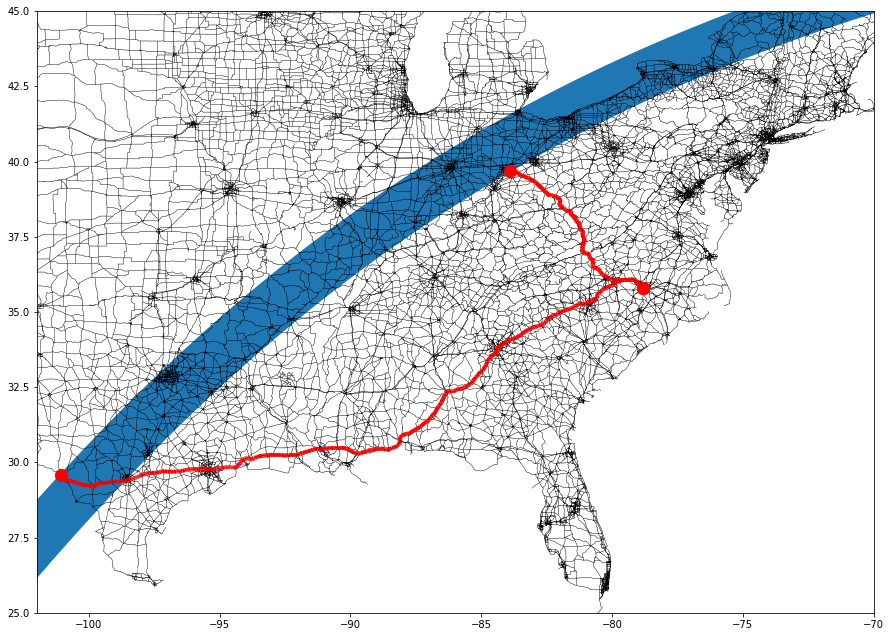

<Figure size 432x288 with 0 Axes>

In [13]:
fig, ax = eastern_road_plot()

for pw in [opw['path_weight'].min(), opw['path_weight'].max()]:    
    source, sink, pathweight = opw[opw['path_weight'] == pw].values[0]
    plot_path(ax, opl, cary_node, sink)
    print_drive_duration(source, sink, pathweight)

fig

## Shortest Path to Each Duration Band
Since the duration of the total eclipse is shorter the further away you are from the centerline of the umbra's path, the closest location to watch the total eclipse only gives us a 60s duration. This doesn't quite cut it for a once-in-a-lifetime event, so let's calculate the shortest path to each duration band to see what other options we have. We do this by looping over each duration band, finding all the cities within that duration band, and then calculating the shortest path to that collection of cities. Excitingly, we discover that with only 30 more minutes of driving we can end up in a position where we get a much longer eclipse duration!

Eclipse at 'New Lisbon,IN,-85.262669,39.862315' with duration 240s and drive time 8.86hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'West Mansfield,OH,-83.544004,40.401388' with duration 210s and drive time 8.05hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Magnetic Springs,OH,-83.262739,40.353699' with duration 180s and drive time 7.85hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Marysville,OH,-83.35936,40.227986' with duration 150s and drive time 7.8hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'New California,OH,-83.23666,40.146587' with duration 120s and drive time 7.69hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Dublin,OH,-83.145774,40.113304' with duration 90s and drive time 7.61hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Wilberforce,OH,-83.884442,39.714974' with duration 60s and drive time 7.52hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Cedarville,OH,-83.812175,39.748429' with duration 30s and drive time 7.53hrs from 'Cary,NC,-7

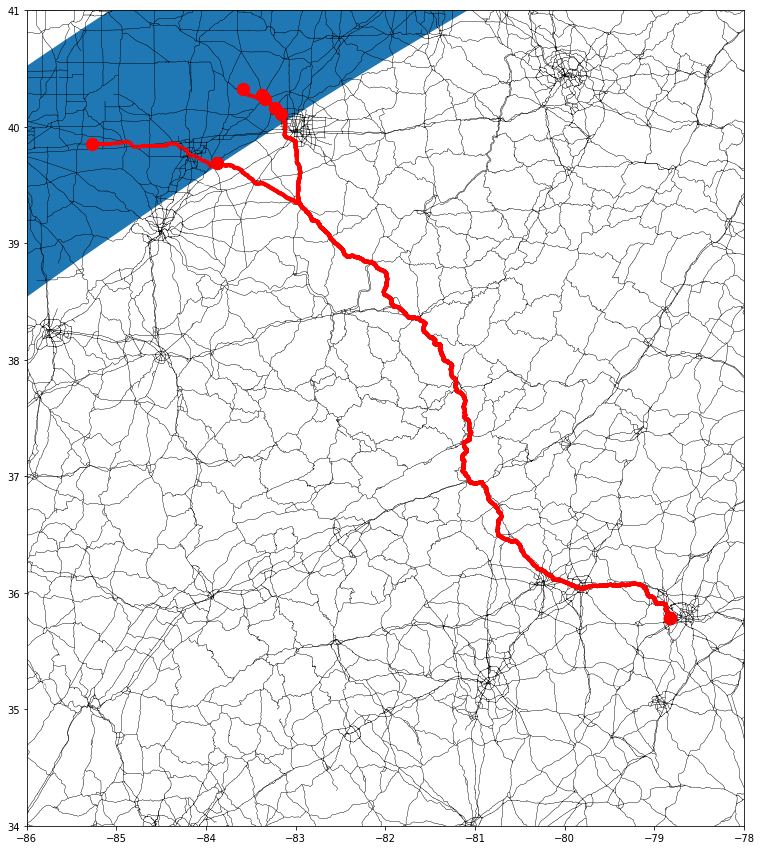

<Figure size 432x288 with 0 Axes>

In [14]:
fig, ax = eastern_road_plot()
_ = ax.set_xlim((-86,-78))
_ = ax.set_ylim((34,41))

for duration in duration_gdf.Duration.values:
    node_subset = cities_inside_gdf[cities_inside_gdf.duration == duration][['node']].copy()
    node_subset['sink'] = 1
    s.upload(node_subset, casout={'name':'node_subset', 'replace':True})

    res = s.network.shortestPath(
        graph          = gid,
        nodesSubset    = {'name': 'node_subset'},
        source         = cary_node,    
        outPathsLinks  = {'name': 'outPathsLinks', 'replace':True},
        outWeights     = {'name': 'outWeights', 'replace':True},
    )

    opw = s.CASTable('outWeights')
    opl = s.CASTable('outPathsLinks')

    source, sink, pathweight = opw[opw['path_weight'] == opw['path_weight'].min()].values[0]
    plot_path(ax, opl, cary_node, sink)
    print_drive_duration(source, sink, pathweight)

fig

## Shortest Path with Sequence
Since we are traveling so far for this event, we want to make a road trip out of it and visit some family and friends, and hopefully convince them to join us. There are a few stops we want to make on the way and ultimately travel to our final destination of New Lisbon, IN, the closest place with the maximum duration. Although, New Lisbon may not be the closest place in totality from our penultimate stop, it still gives us the shortest path back to home and is a good final stop. Of course, we need a new route to accomodate these extra stops. We can find the shortest path through this sequence of stops with the shortestPath action.

In [15]:
# first save the direct path to New Lisbon from last section to plot here as well.

sequence = [
    [city_to_node["Cary,NC,-78.823444,35.781302"], 1],
    [city_to_node["Asheville,NC,-82.552725,35.570972"], 2],
    [city_to_node["Knoxville,TN,-83.94927,35.97068"], 3,],
    [city_to_node["Cincinnati,OH,-84.505829,39.140183"], 4],
    [city_to_node["New Lisbon,IN,-85.262669,39.862315"], 5],
]

df = pd.DataFrame(sequence, columns=['node','sequence'])
s.upload(df, casout={'name':'node_subset', 'replace':True})

res = s.network.shortestPath(
    graph          = gid,
    nodesSubset    = {'name': 'node_subset'},
    sequence       = "sequence",
    outPathsLinks  = {'name': 'outPathsLinks', 'replace':True},
    outWeights     = {'name':'outPathWeights', 'replace':True},
)

opw = s.CASTable('outPathWeights')
opl = s.CASTable('outPathsLinks')

Eclipse at 'New Lisbon,IN,-85.262669,39.862315' with duration 240s and drive time 11.05hrs from 'Cary,NC,-78.823444,35.781302'.


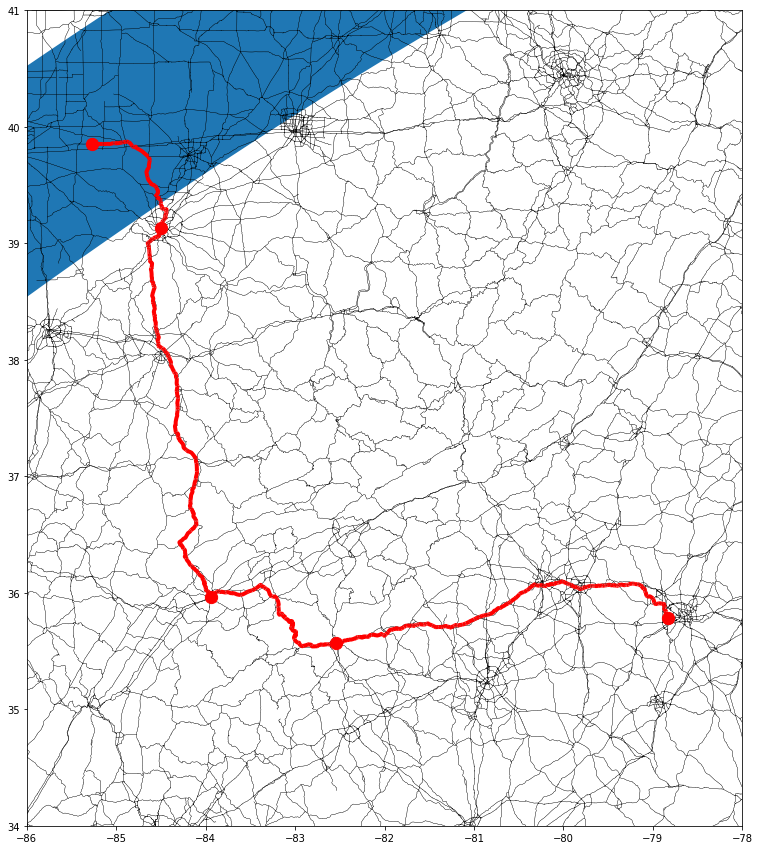

<Figure size 432x288 with 0 Axes>

In [16]:
fig, ax = eastern_road_plot()
_ = ax.set_xlim((-86,-78))
_ = ax.set_ylim((34,41))

source, sink, pathweight = opw.values[0]
plot_path(ax, opl)
print_drive_duration(source, sink, pathweight)
for node, _ in sequence:
    nodes_gdf.loc[[node]].plot(ax=ax, zorder=2, color='red', markersize=150)
    
fig

# Finding Other Places to Visit Using Community Detection

All the routes we have mapped so far have taken us into the midwest, as this is the closest point to the total eclipse from Cary, NC. However, we are also interested in seeing other potential routes to take in other regions in the path of the eclipse. Since there are so many cities, it is overwhelming to look at each one, so let's use the community action to partition the cities in the path of totality into groups and then examine routes to a single node in that group. For each community, we will choose the node that has the maximum duration, breaking any ties by shortest travel time.

In [17]:
df = cities_inside_gdf[['node']].copy()
df['source'] = 1
df['sink'] = 1

s.upload(df, casout={'name':'node_subset', 'replace':True})

# all pairs shortest path, but link between nodes only if less than an hour of travel time between them
res = s.network.shortestPath(
    graph          = gid,
    maxPathWeight  = 3600,
    nodesSubset    = {'name': 'node_subset'},
    outWeights     = {'name':'outPathWeights', 'replace':True},
)

res = s.datastep.runCode(
    code="""
        data outPathWeights;
            set outPathWeights;
            invweight = 1 / path_weight;
        run;
    """
)

In [18]:
s.network.community(
    direction      = 'directed',
    links          = {'name':'outPathWeights'},
    linksVar       = {'from': 'source', 'to':'sink', 'weight':'invweight', 'vars':['path_weight']},
    algorithm      = "louvain",
    resolutionList = 0.5,
    outCommunity   = {'name': 'outCommunity', 'replace':True},
    outNodes       = {'name': 'outNodes', 'replace':True},
    outLinks       = {'name': 'outLinks', 'replace':True},
)

oc = s.CASTable('outCommunity')
ol = s.CASTable('outLinks')
on = s.CASTable('outNodes')

oc = oc[oc['nodes'] > 20] # Only keep the large communities
oc.to_frame()

Selected Rows from Table OUTCOMMUNITY

    level  resolution  community  nodes  intra_links  inter_links   density  cut_ratio  conductance
0     0.0         0.5        0.0  311.0      17524.0        460.0  0.181765   0.000701     0.025578
1     0.0         0.5        1.0  319.0      21903.0        571.0  0.215916   0.000851     0.025407
2     0.0         0.5        2.0  267.0      33092.0       2460.0  0.465940   0.004275     0.069194
3     0.0         0.5        3.0  273.0      20082.0       3102.0  0.270443   0.005287     0.133799
4     0.0         0.5        4.0   34.0        928.0        788.0  0.827094   0.009705     0.459207
5     0.0         0.5        8.0  136.0       5089.0        302.0  0.277179   0.000971     0.056019
6     0.0         0.5        9.0  204.0       8624.0        880.0  0.208249   0.001945     0.092593
7     0.0         0.5       10.0   63.0       1396.0        375.0  0.357399   0.002523     0.211745
8     0.0         0.5       11.0   74.0       1464.0        379.0  0.271011   0.002181     0.205643
9     0.0         0.5       13.0  124.0       3136.0         87.0  0.205612   0.000305     0.026993
10    0.0         0.5       14.0  129.0       5622.0       1049.0  0.340480   0.003546     0.157248
11    0.0         0.5       15.0  305.0      20891.0       2297.0  0.225313   0.003557     0.099060
12    0.0         0.5       20.0   91.0       2288.0         40.0  0.279365   0.000189     0.017182

Eclipse at 'Erie,PA,-80.073503,42.116594' with duration 210s and drive time 9.45hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Cumby,TX,-95.838533,33.13512' with duration 240s and drive time 16.6hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Caledonia,OH,-82.969513,40.636429' with duration 210s and drive time 8.2hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'West Mansfield,OH,-83.544004,40.401388' with duration 210s and drive time 8.05hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'McKean,PA,-80.139587,41.998484' with duration 210s and drive time 9.25hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Springfield,AR,-92.554988,35.272887' with duration 240s and drive time 13.58hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Wayne City,IL,-88.589407,38.347644' with duration 240s and drive time 10.82hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Powhatan,AR,-91.123884,36.087312' with duration 240s and drive time 12.74hrs from 'Cary,NC,-78.823444,35.78130

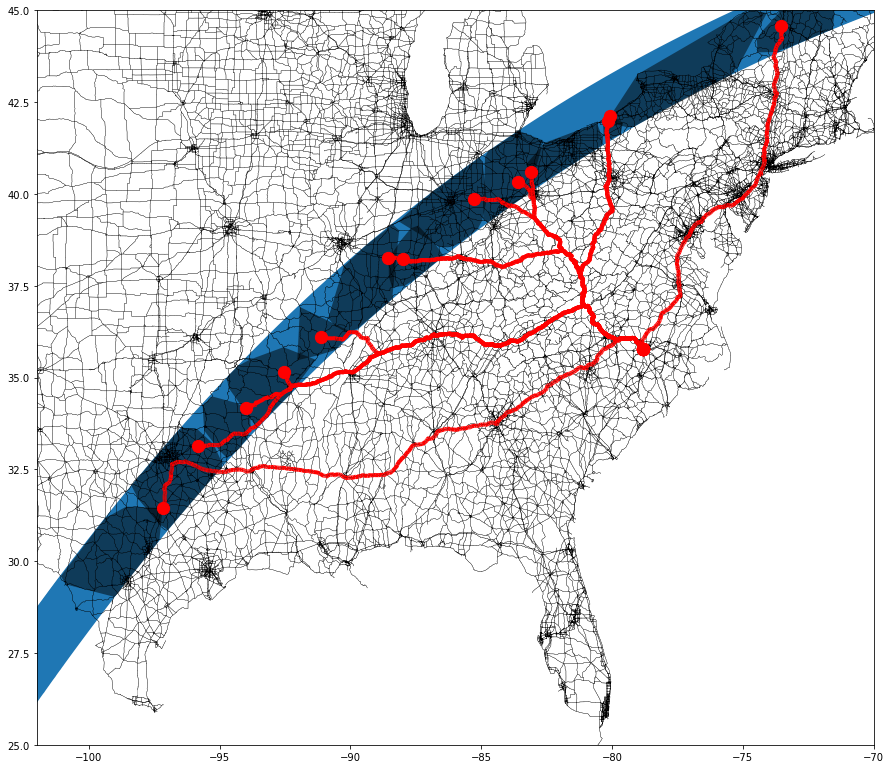

<Figure size 432x288 with 0 Axes>

In [19]:
fig, ax = eastern_road_plot()

df = cities_inside_gdf[['node']].copy()
df['sink'] = 1
s.upload(df, casout={'name':'node_subset', 'replace':True})

res = s.network.shortestPath(
    graph          = gid,
    source         = cary_node,
    nodesSubset    = {'name': 'node_subset'},
    outWeights     = {'name': 'outWeights', 'replace':True},
    outPathsLinks  = {'name': 'outPathsLinks', 'replace':True},
)

opl = s.CASTable('outPathsLinks')
opw = s.CASTable('outWeights').to_frame()
opw = opw.merge(on.to_frame(), left_on='sink', right_on='node').drop(columns=['node']) # merge community identifier
opw = opw.merge(nodes_gdf[['node', 'duration', 'geometry']], left_on='sink', right_on='node') # merge duration and geometry values
opw = gpd.GeoDataFrame(opw, geometry='geometry')

for cid in oc['community'].values:
    gdf = opw[opw.community_0==cid]

    # plot the convex hull of set of nodes in the community
    points = gdf.dissolve()['geometry']
    points.convex_hull.plot(ax=ax, zorder=1, color='black', alpha=0.5)

    # find the node with largest eclipse duration that is closest to the source
    gdf = gdf[gdf.duration == gdf.duration.max()]
    idxmin = gdf.path_weight.idxmin()
    destination = gdf.loc[idxmin].sink

    # get the path to the node in the community
    source, sink, pathweight = opw[opw.sink==destination][['source', 'sink', 'path_weight']].values[0]
    plot_path(ax, opl[opl.sink==sink], source, sink)
    print_drive_duration(source, sink, pathweight)


fig

## Finding the Best Meeting Point Using Multiple Source Shortest Paths

We want to figure out the best meeting spot to for friends and family to gather to watch the total eclipse together. The difficulty is that all these people are spread across the USA. However, we can easily solve this by using the shortestPath action, this time with multiple source (and sink) nodes. Then, we aggregate the results to find the location that has the smallest maximum drive time, to limit the amount that one group has to drive over another.


In [20]:
source_nodes = [
    {'node':city_to_node["Cary,NC,-78.823444,35.781302"], 'source':1, 'sink':0},
    {'node':city_to_node["Houston,TX,-95.388806,29.785743"], 'source':1, 'sink':0},
    {'node':city_to_node["Seattle,WA,-122.351538,47.619335"], 'source':1, 'sink':0},
    {'node':city_to_node["San Diego,CA,-117.135562,32.814977"], 'source':1, 'sink':0},
    {'node':city_to_node["Boston,MA,-71.018253,42.338551"], 'source':1, 'sink':0}
]

node_subset = cities_inside_gdf[['node']].copy()
node_subset['sink'] = 1
node_subset['source'] = 0
node_subset = node_subset.append(source_nodes, ignore_index=True)
s.upload(node_subset, casout={'name':'node_subset', 'replace':True})

res = s.network.shortestPath(
    graph          = gid,
    nodesSubset    = {'name': 'node_subset'},
    outPathsLinks  = {'name': 'outPathsLinks', 'replace':True},
    outWeights     = {'name': 'outWeights', 'replace':True},
)

opw = s.CASTable('outWeights').to_frame()
opl = s.CASTable('outPathsLinks')

Eclipse at 'Greenwood,AR,-94.276391,35.226857' with duration 120s and drive time 29.74hrs from 'Seattle,WA,-122.351538,47.619335'.
Eclipse at 'Greenwood,AR,-94.276391,35.226857' with duration 120s and drive time 7.83hrs from 'Houston,TX,-95.388806,29.785743'.
Eclipse at 'Greenwood,AR,-94.276391,35.226857' with duration 120s and drive time 15.42hrs from 'Cary,NC,-78.823444,35.781302'.
Eclipse at 'Greenwood,AR,-94.276391,35.226857' with duration 120s and drive time 24.24hrs from 'Boston,MA,-71.018253,42.338551'.
Eclipse at 'Greenwood,AR,-94.276391,35.226857' with duration 120s and drive time 21.76hrs from 'San Diego,CA,-117.135562,32.814977'.


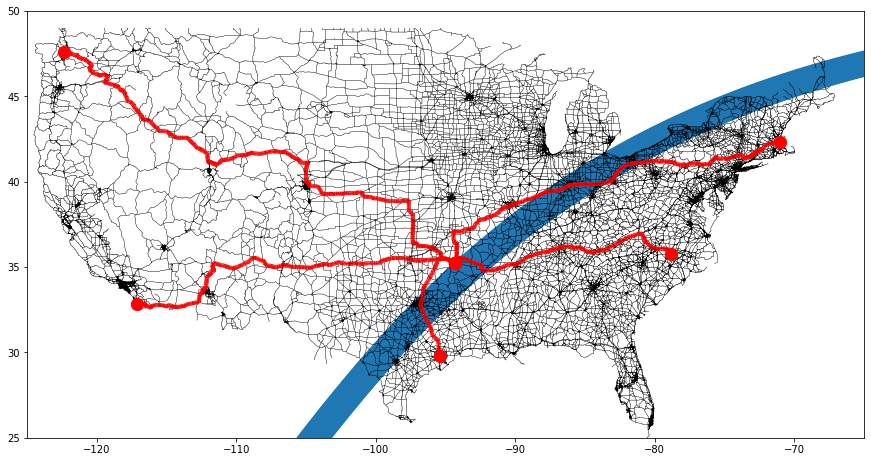

<Figure size 432x288 with 0 Axes>

In [21]:
fig, ax = full_road_plot()

best = opw.groupby('sink')['path_weight'].max().idxmin() # sink with the smallest maximum drive time from any source

for source, sink, pathweight in opw[opw.sink==best].values:
    plot_path(ax, opl, source, sink)
    print_drive_duration(source, sink, pathweight)

fig

[[1]]() Map data from [Open Street Maps](https://www.openstreetmap.org) is made available here under the [Open Database License (ODbL)](https://www.openstreetmap.org/copyright).